In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

In [2]:
# Nicer plotting
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (8,4)

# Movie example using write_beam

Here we insert write_beam elements into an existing lattice, run, save the beams to an h5 file, and plot using openPMD-beamphysics tools

In [3]:
from impact import Impact, template_dir
from distgen import Generator
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
IMPACT_IN = os.path.join(template_dir,'apex_gun/ImpactT.in')
DISTGEN_IN = os.path.join(template_dir,'apex_gun/distgen.yaml')
os.path.exists(IMPACT_IN)

True

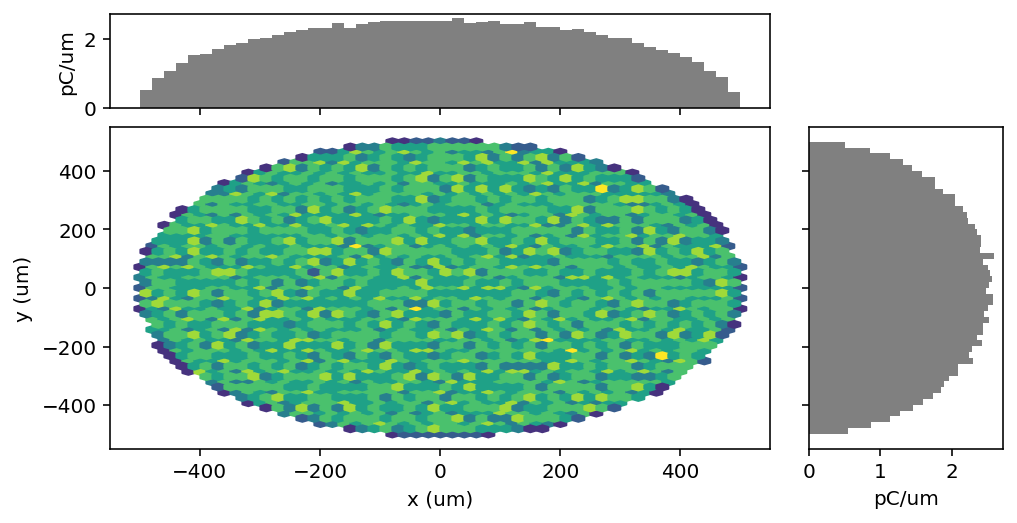

In [5]:
G = Generator(DISTGEN_IN)
G['n_particle'] = 10000
G.run()
P0 = G.particles
P0.plot('x', 'y')

In [6]:
# Make Impact object
I = Impact(IMPACT_IN, initial_particles = P0, verbose=True)


# Change some things
I.header['Nx'] = 32
I.header['Ny'] = 32
I.header['Nz'] = 32
I.header['Dt'] = 1e-13

I.total_charge = P0['charge']
# Change stop location
I.stop = 0.1


================ Impact-T Summary ================    
10000 particles
1 bunch of electrons
total charge: 0.0 pC
Distribution type: read
Cathode start at z = 0 m
   emission time: 1.2e-12 s
   image charges neglected after z = 0.02 m
Processor domain: 1 x 1 = 1 CPUs
Space charge grid: 16 x 16 x 16
Maximum time steps: 1000000
Reference Frequency: 1300000000.0 Hz
Initial reference time: 0.0 s
Simulation starting from the beginning

Configured to run in: /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmp56ir7cyt
Removed element: stop_1
Set stop to s = 0.1


In [7]:
# Make new elements
def new_write_beam(s, i, sample_frequency=1):
    if i in [40, 50]:
        print('Warning: will overwrite standard output files')
    ele = {'type':'write_beam', 'sample_frequency':sample_frequency}
    ele['filename'] = 'fort.'+str(i)
    ele['name'] = 'write_beam_'+str(i)
    ele['s'] = s
    return ele
def new_write_beams(slist, istart, sample_frequency=1):
    eles = []
    if len(slist) > 100:
        print('Warning: the maximum number of phase-space files which can be output is 100.')
    i = istart
    for s in slist:
        ele = new_write_beam(s, i, sample_frequency)
        eles.append(ele)
        i += 1
    return eles
slist = np.linspace(0.001, 0.1, 99)
neweles = new_write_beams(slist, 100)

In [8]:
# Prepend these to the lattice
I.input['lattice'] = neweles + I.input['lattice']

In [9]:
I.timeout = 1000
I.run()

Running Impact-T in /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmp56ir7cyt
writing 10000 particles to /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmp56ir7cyt/partcl.data
Cathode start with cathode_kinetic_energy_ref = 1.0 eV
Cathode start: Replaced Np with 10000 according to initial particles
Cathode start: Replaced Bkenergy with 1.0 according to initial particles
Cathode start: Replaced Temission with 5.1434708345824233e-11 according to initial particles
Cathode start: Replaced Tini with -2.563423239338539e-11 according to initial particles
Setting total charge to 1.0000000000000004e-10 C
Loaded fort 30 : Fourth root of the fourth moments of the beam distribution
Loaded fort 25 : RMS Y information
Loaded fort 24 : RMS X information
Loaded fort 26 : RMS Z information
Loaded fort 28 : Load balance and loss diagnostics
Loaded fort 29 : Cube root of third moments of the beam distribution
Loaded fort 18 : Time and energy
Loaded fort 27 : Max amplitude information
Loaded fort 70 

In [10]:
len(I.particles)

101

# Plot

In [29]:
from bokeh.plotting import  show, figure, output_notebook
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource
from bokeh import palettes, colors
pal = palettes.Viridis[256]
white=colors.named.white
pal = list(pal)
pal[0] = white # replace 0 with white
pal = tuple(pal)
output_notebook(verbose=False, hide_banner=True)
import os

In [30]:
# Prepare histogram function

PL = I.particles

ilist = []
for k in PL:
    if k.startswith('write_beam_'):
        ilist.append(int(k.strip('write_beam_')))

def bin_particles(i, key1='x', key2='y', bins=40):
    
    P = I.particles[f'write_beam_{i}']
    
    return np.histogram2d(P[key1], P[key2], weights=P.weight, bins=bins)
bin_particles(100)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-5.61832975e-04, -5.33690529e-04, -5.05548083e-04, -4.77405638e-04,
        -4.49263192e-04, -4.21120746e-04, -3.92978300e-04, -3.64835855e-04,
        -3.36693409e-04, -3.08550963e-04, -2.80408517e-04, -2.52266072e-04,
        -2.24123626e-04, -1.95981180e-04, -1.67838734e-04, -1.39696289e-04,
        -1.11553843e-04, -8.34113972e-05, -5.52689514e-05, -2.71265057e-05,
         1.01594006e-06,  2.91583858e-05,  5.73008315e-05,  8.54432773e-05,
         1.13585723e-04,  1.41728169e-04,  1.69870614e-04,  1.98013060e-04,
         2.26155506e-04,  2.54297952e-04,  2.82440397e-04,  3.10582843e-04,
         3.38725289e-04,  3.66867735e-04,  3.95010180e-04,  4.23152626e-04,
         4.51295072e-04,  4.79437518e-04,  5.07579963e-04,  5.35722

In [13]:
# Prepare a datasource for Bokeh

def bin_bunch_datasource_h5(i, key1, key2,  bins=20, nice=True, liveOnly=True, liveStatus=1):
    H, xedges, yedges = bin_particles(i, key1, key2, bins=bins)
    xmin = min(xedges)
    xmax = max(xedges)
    ymin = min(yedges)
    ymax = max(yedges)
    
    
    #if nice:
    #    f1 = nice_phase_space_factor[component1]
    #    f2 = nice_phase_space_factor[component2]
    #    xlabel =  nice_phase_space_label[component1]
    #    ylabel =  nice_phase_space_label[component2]
    #    xmin *= f1
    #    xmax *= f1
    #    ymin *= f2
    #    ymax *= f2
    #else:
    #    xlabel = component1
    #    ylabel = component2
    
    # Form datasource
    dat = {'image':[H.transpose()], 'xmin':[xmin], 'ymin':[ymin], 'dw':[xmax-xmin], 'dh':[ymax-ymin]}
    dat['xmax'] = [xmax]
    dat['ymax'] = [ymax]
    
    ds = ColumnDataSource(data=dat)
    
    return ds
ds = bin_bunch_datasource_h5(100, 'x', 'y')

In [19]:

plot = figure(#x_range=[xmin,xmax], y_range=[ymin,ymax], 
              #    x_axis_label = xlabel,  y_axis_label = ylabel,
               plot_width=500, plot_height=500)
plot.image(image='image', x='xmin', y='ymin', dw='dw', dh='dh', source=ds,palette=pal)
show(plot)

# Interactive 

In [15]:
from bokeh.models.widgets import Slider
from bokeh import palettes, colors


In [26]:
# interactive
def myapp2(doc):
    
    bunches = ilist
    
    doc.bunchi = bunches[0]
    doc.component1 = 'x'
    doc.component2 = 'px' 
    doc.xlabel = doc.component1
    doc.ylabel = doc.component2

    doc.bins = 100
    
    #doc.range = FULLRANGE
    ds  = bin_bunch_datasource_h5(doc.bunchi, doc.component1, doc.component2,bins=doc.bins) 

    def refresh():
        ds.data  = dict(bin_bunch_datasource_h5(doc.bunchi, doc.component1, doc.component2,bins=doc.bins).data )
    
    # Default plot
  
    plot = figure(title='',  
                  x_axis_label = doc.xlabel, y_axis_label = doc.ylabel,
           plot_width=500, plot_height=500)    
    plot.image(image='image', x='xmin', y='ymin', dw='dw', dh='dh', source=ds, palette=pal)
    
    def slider_handler(attr, old, new):
        doc.bunchi =  bunches[new]
        refresh()

    slider = Slider(start=0, end=len(bunches)-1, value=0, step=1, title='x')             
    slider.on_change('value', slider_handler)

    # Add plot to end
    doc.add_root(column(slider, plot))
show(myapp2)# , notebook_url=remote_jupyter_proxy_url)

In [21]:
# If there are multiple 
import os
os.environ['BOKEH_ALLOW_WS_ORIGIN'] = 'localhost:8890'

In [18]:
40 * 175

7000